This notebooks shows how to use code interpreter [OpenAI assistant](https://platform.openai.com/docs/assistants/tools/code-interpreter). This tool generates the code and executes the code in the sandbox.
- steps:
  - create an assistant (LLM with code interpreter)
  - call the assistant to write the code, and executes the code in the sandbox (this might contain multiple rounds in order to get the answer)
  - get the answer from the assistant
- the input data are: [`air_passengers.csv`](../../data/air_passengers.csv), [`melbourne_temp.csv`](../../data/melbourne_temp.csv), [`nyc_taxi.csv`](../../data/nyc_taxi.csv)
- the question is: [`easy_precise_questions.csv`](../../data/easy_precise_questions.csv)

In [1]:
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from IPython.display import Image
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.utils import convert_types, eval
from utils.vars import DATA_DIR, EXCEPT_FILES, QUESTION_PATH
from utils.assistants import AzureOpenAIAssistant

load_dotenv()

ASSISTANT_NAME_PREFIX = "code_interpreter"

In [2]:
# don't need to define function provide more flexibility but more prompt tokens and execution time but less accurate (need to give more accurate instruction). slower compared to function calling.

In [3]:
# get the client object
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-05-01-preview",  # only support this version
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)
assistant = AzureOpenAIAssistant(client=client)

In [4]:
display(assistant.list_all_assistants())

,id,created_at,description,instructions,metadata,model,name,object,tools,response_format,temperature,tool_resources,top_p
0,asst_Vlp2LN1jLT9DF3VaW0lBJ1tr,1734136705,None,You are a data scientist in univariate time se...,{},gpt-4o,customized_func_nyc_taxi,assistant,[{'function': {'name': 'get_time_col_and_targe...,auto,0.0,{},1.0
1,asst_QiuowqUHhjLjLdZLHogxZ6Aq,1734136645,None,You are a data scientist in univariate time se...,{},gpt-4o,customized_func_melbourne_temp,assistant,[{'function': {'name': 'get_time_col_and_targe...,auto,0.0,{},1.0
2,asst_BWLHvd0JyHSkCD1y2MaumwMQ,1734136577,None,You are a data scientist in univariate time se...,{},gpt-4o,customized_func_air_passengers,assistant,[{'function': {'name': 'get_time_col_and_targe...,auto,0.0,{},1.0
3,asst_x4c0gSGzdmoljHa4DrmZjPZO,1734135165,None,You are a python expert in univariate time ser...,{},gpt-4o,code_interpreter_nyc_taxi_plot,assistant,[{'type': 'code_interpreter'}],auto,0.0,{'code_interpreter': {'file_ids': ['assistant-...,1.0
4,asst_3PTBym6cvEQGfOUYS2GauhSd,1734134708,None,You are a data scientist in univariate time se...,{},gpt-4o,code_interpreter_nyc_taxi,assistant,[{'type': 'code_interpreter'}],auto,0.0,{'code_interpreter': {'file_ids': ['assistant-...,1.0
5,asst_wgsQ9A5m5ucnSBRS5twZLEY9,1734134569,None,You are a data scientist in univariate time se...,{},gpt-4o,code_interpreter_melbourne_temp,assistant,[{'type': 'code_interpreter'}],auto,0.0,{'code_interpreter': {'file_ids': ['assistant-...,1.0
6,asst_oACu0AnZwnQubgMwDap6jcKI,1734134414,None,You are a data scientist in univariate time se...,{},gpt-4o,code_interpreter_air_passengers,assistant,[{'type': 'code_interpreter'}],auto,0.0,{'code_interpreter': {'file_ids': ['assistant-...,1.0


In [5]:
# delete assistant
assistant.delete_assistant(name=f"{ASSISTANT_NAME_PREFIX}_nyc_taxi")
assistant.delete_assistant(name=f"{ASSISTANT_NAME_PREFIX}_melbourne_temp")
assistant.delete_assistant(name=f"{ASSISTANT_NAME_PREFIX}_air_passengers")

display(assistant.list_all_assistants())

,id,created_at,description,instructions,metadata,model,name,object,tools,response_format,temperature,tool_resources,top_p
0,asst_Vlp2LN1jLT9DF3VaW0lBJ1tr,1734136705,None,You are a data scientist in univariate time se...,{},gpt-4o,customized_func_nyc_taxi,assistant,[{'function': {'name': 'get_time_col_and_targe...,auto,0.0,{},1.0
1,asst_QiuowqUHhjLjLdZLHogxZ6Aq,1734136645,None,You are a data scientist in univariate time se...,{},gpt-4o,customized_func_melbourne_temp,assistant,[{'function': {'name': 'get_time_col_and_targe...,auto,0.0,{},1.0
2,asst_BWLHvd0JyHSkCD1y2MaumwMQ,1734136577,None,You are a data scientist in univariate time se...,{},gpt-4o,customized_func_air_passengers,assistant,[{'function': {'name': 'get_time_col_and_targe...,auto,0.0,{},1.0
3,asst_x4c0gSGzdmoljHa4DrmZjPZO,1734135165,None,You are a python expert in univariate time ser...,{},gpt-4o,code_interpreter_nyc_taxi_plot,assistant,[{'type': 'code_interpreter'}],auto,0.0,{'code_interpreter': {'file_ids': ['assistant-...,1.0


## Run 3 files x all questions

In [6]:
prompt_path = "prompts/instruction.jinja2"

In [7]:
# read questions
df_questions = pd.read_csv(QUESTION_PATH)

In [8]:
df_result = []
# loop through files
for file_path in Path(DATA_DIR).glob("*.csv"):
    if file_path.name in EXCEPT_FILES:
        continue
    print(f"file: {file_path.name}")

    # check if file has been uploaded to the client
    file_id = assistant.upload_or_retrieve_file(file_path=file_path)

    # create or retrieve an assistant
    assistant_id = assistant.create_or_retrieve(
        prompt_path=prompt_path,
        assistant_name=f"{ASSISTANT_NAME_PREFIX}_{file_path.stem}",
        tools=[{"type": "code_interpreter"}],
        tool_resources={"code_interpreter": {"file_ids": [file_id]}},
    )

    # loop through questions
    for _, row in tqdm(df_questions.iterrows(), total=len(df_questions)):
        question = row["question"]
        answer_true = row[Path(file_path).name]

        result = assistant.ask_a_question(question=question, assistant_id=assistant_id)

        df_result.append(
            {
                **result,
                "file": file_path.name,
                "answer_true": convert_types(answer_true),
            }
        )

file: air_passengers.csv


  0%|          | 0/16 [00:00<?, ?it/s]

file: melbourne_temp.csv


  0%|          | 0/16 [00:00<?, ?it/s]

JSONDecodeError: The file contains two columns: "Date" and "Daily minimum temperatures". The "Date" column can be converted to datetime format, and the "Daily minimum temperatures" column can be converted to float format.

Based on this information, the target column is "Daily minimum temperatures".

{"output": "Daily minimum temperatures"}
file: nyc_taxi.csv


  0%|          | 0/16 [00:00<?, ?it/s]

In [9]:
# eval
df_result = pd.DataFrame(df_result)

# loop through each file
eval(df=df_result, details=True)

File: air_passengers.csv; Accuracy: 1.0
File: melbourne_temp.csv; Accuracy: 0.9375
question: What is the target column?
answer_pred: The file contains two columns: "Date" and "Daily minimum temperatures". The "Date" column can be converted to datetime format, and the "Daily minimum temperatures" column can be converted to float format.

Based on this information, the target column is "Daily minimum temperatures".

{"output": "Daily minimum temperatures"}
answer_true: Daily minimum temperatures
messages: user: What is the target column?
assistant: To identify the target column, I will first read the file and inspect its contents. Let's start by loading the file and examining the first few rows.
assistant: The file contains two columns: "Date" and "Daily minimum temperatures". The "Date" column can be converted to datetime format, and the "Daily minimum temperatures" column can be converted to float format.

Based on this information, the target column is "Daily minimum temperatures".

{

In [10]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_result.groupby(["file"]).describe())

completion_tokens                                     \
                               count      mean        std   min     25%   
file                                                                      
air_passengers.csv              16.0  180.1250  79.998229  73.0  140.25   
melbourne_temp.csv              16.0  174.3750  48.191113  71.0  163.50   
nyc_taxi.csv                    16.0  169.0625  71.498689  74.0  135.00   

                                         prompt_tokens                     \
                      50%     75%    max         count    mean        std   
file                                                                        
air_passengers.csv  174.0  215.25  384.0          16.0  611.75  93.431258   
melbourne_temp.csv  174.5  198.50  252.0          16.0  611.00  69.681179   
nyc_taxi.csv        165.5  191.75  363.0          16.0  645.00  90.641418   

                                                       total_tokens            \
                      min     25%    50%    75%    max        count      mean   
file                                                                            
air_passengers.csv  433.0  579.25  611.5  657.5  826.0         16.0  791.8750   
melbourne_temp.csv  431.0  606.25  620.0  649.5  700.0         16.0  785.3750   
nyc_taxi.csv        437.0  620.00  650.5  680.0  848.0         16.0  814.0625   

                                                                      \
                           std    min     25%    50%     75%     max   
file                                                                   
air_passengers.csv  172.571869  512.0  719.50  785.5  873.00  1210.0   
melbourne_temp.csv  116.120555  510.0  764.75  794.5  848.00   952.0   
nyc_taxi.csv        159.963108  518.0  755.00  816.5  871.75  1211.0   

                   execution_time_s                                         \
                              count    mean       std  min   25%  50%  75%   
file                                                                         
air_passengers.csv             16.0  7.6875  4.028544  3.0  5.75  6.5  9.0   
melbourne_temp.csv             16.0  6.7500  1.770122  5.0  6.00  6.0  7.0   
nyc_taxi.csv                   16.0  7.4375  2.657536  4.0  6.00  6.0  8.5   

                          
                     max  
file                      
air_passengers.csv  18.0  
melbourne_temp.csv  12.0  
nyc_taxi.csv        13.0

## Run one question

In [11]:
# list all assistants
assistant.list_all_assistants()

,id,created_at,description,instructions,metadata,model,name,object,tools,response_format,temperature,tool_resources,top_p
0,asst_VGmOogPrbDPXHIJeUbVmWWzZ,1734137131,None,You are a data scientist in univariate time se...,{},gpt-4o,code_interpreter_nyc_taxi,assistant,[{'type': 'code_interpreter'}],auto,0.0,{'code_interpreter': {'file_ids': ['assistant-...,1.0
1,asst_0Qc1dyLAY7XD3dKLqIkNJ45l,1734137012,None,You are a data scientist in univariate time se...,{},gpt-4o,code_interpreter_melbourne_temp,assistant,[{'type': 'code_interpreter'}],auto,0.0,{'code_interpreter': {'file_ids': ['assistant-...,1.0
2,asst_hTacjFmXp0wJW7cTacgiIaVm,1734136870,None,You are a data scientist in univariate time se...,{},gpt-4o,code_interpreter_air_passengers,assistant,[{'type': 'code_interpreter'}],auto,0.0,{'code_interpreter': {'file_ids': ['assistant-...,1.0
3,asst_Vlp2LN1jLT9DF3VaW0lBJ1tr,1734136705,None,You are a data scientist in univariate time se...,{},gpt-4o,customized_func_nyc_taxi,assistant,[{'function': {'name': 'get_time_col_and_targe...,auto,0.0,{},1.0
4,asst_QiuowqUHhjLjLdZLHogxZ6Aq,1734136645,None,You are a data scientist in univariate time se...,{},gpt-4o,customized_func_melbourne_temp,assistant,[{'function': {'name': 'get_time_col_and_targe...,auto,0.0,{},1.0
5,asst_BWLHvd0JyHSkCD1y2MaumwMQ,1734136577,None,You are a data scientist in univariate time se...,{},gpt-4o,customized_func_air_passengers,assistant,[{'function': {'name': 'get_time_col_and_targe...,auto,0.0,{},1.0
6,asst_x4c0gSGzdmoljHa4DrmZjPZO,1734135165,None,You are a python expert in univariate time ser...,{},gpt-4o,code_interpreter_nyc_taxi_plot,assistant,[{'type': 'code_interpreter'}],auto,0.0,{'code_interpreter': {'file_ids': ['assistant-...,1.0


In [13]:
question = "What is the target column?"
assistant_id = "asst_VGmOogPrbDPXHIJeUbVmWWzZ"
print(
    f'answer_true: {df_questions[df_questions["question"] == question]["nyc_taxi.csv"].values[0]}'
)
result = assistant.ask_a_question(question=question, assistant_id=assistant_id)
result

answer_true: #Passengers


{'completion_tokens': 74,
 'prompt_tokens': 542,
 'total_tokens': 616,
 'question': 'What is the target column?',
 'answer_pred': '#Passengers',
 'messages': ['user: What is the target column?',
  'assistant: {"output": "#Passengers"}'],
 'steps': [{'name': 'code_interpreter',
   'input': "import pandas as pd\n\n# Load the CSV file\nfile_path = '/mnt/data/assistant-7uNhPHtn8E9L61F5Cp0rUOYR'\ndata = pd.read_csv(file_path)\n\n# Display the first few rows of the dataframe\ndata.head()",
   'output': None,
   'args': None}],
 'attachments': [],
 'execution_time_s': 4}

## Appendix: Generate an image

In [14]:
prompt_path = "prompts/draw_picture.jinja2"
question = "Generate a box plot of the target column using seaborn with text annotation for min, max, q1, q3, and median."
file_path = Path(DATA_DIR) / "nyc_taxi.csv"
file_id = assistant.upload_or_retrieve_file(file_path=file_path)

In [15]:
assistant_id = assistant.create_or_retrieve(
    assistant_name=f"{ASSISTANT_NAME_PREFIX}_{file_path.stem}_plot",
    prompt_path=prompt_path,
    tools=[{"type": "code_interpreter"}],
    tool_resources={"code_interpreter": {"file_ids": [file_id]}},
)
result = assistant.ask_a_question(question=question, assistant_id=assistant_id)

# print the output
print(f'messages: {"\n".join(result["messages"])}')
print(f'steps: {result["steps"]}')

JSONDecodeError: The box plot of the `#Passengers` column has been generated with text annotations for min, max, q1, q3, and median. The plot has also been saved as a PNG file.

You can download the plot using the following link: [box_plot_passengers.png](sandbox:/mnt/data/box_plot_passengers.png)
messages: user: Generate a box plot of the target column using seaborn with text annotation for min, max, q1, q3, and median.
assistant: Let's start by loading the dataset and inspecting its contents to identify the target column and the time column. Then, we will generate the box plot with text annotations for min, max, q1, q3, and median using seaborn.

First, let's load the dataset and inspect its contents.
assistant: The dataset contains two columns: "time" and "#Passengers". The "time" column is the time column, and the "#Passengers" column is the target column.

Next, let's generate the box plot with text annotations for min, max, q1, q3, and median using seaborn.
assistant: The box plo

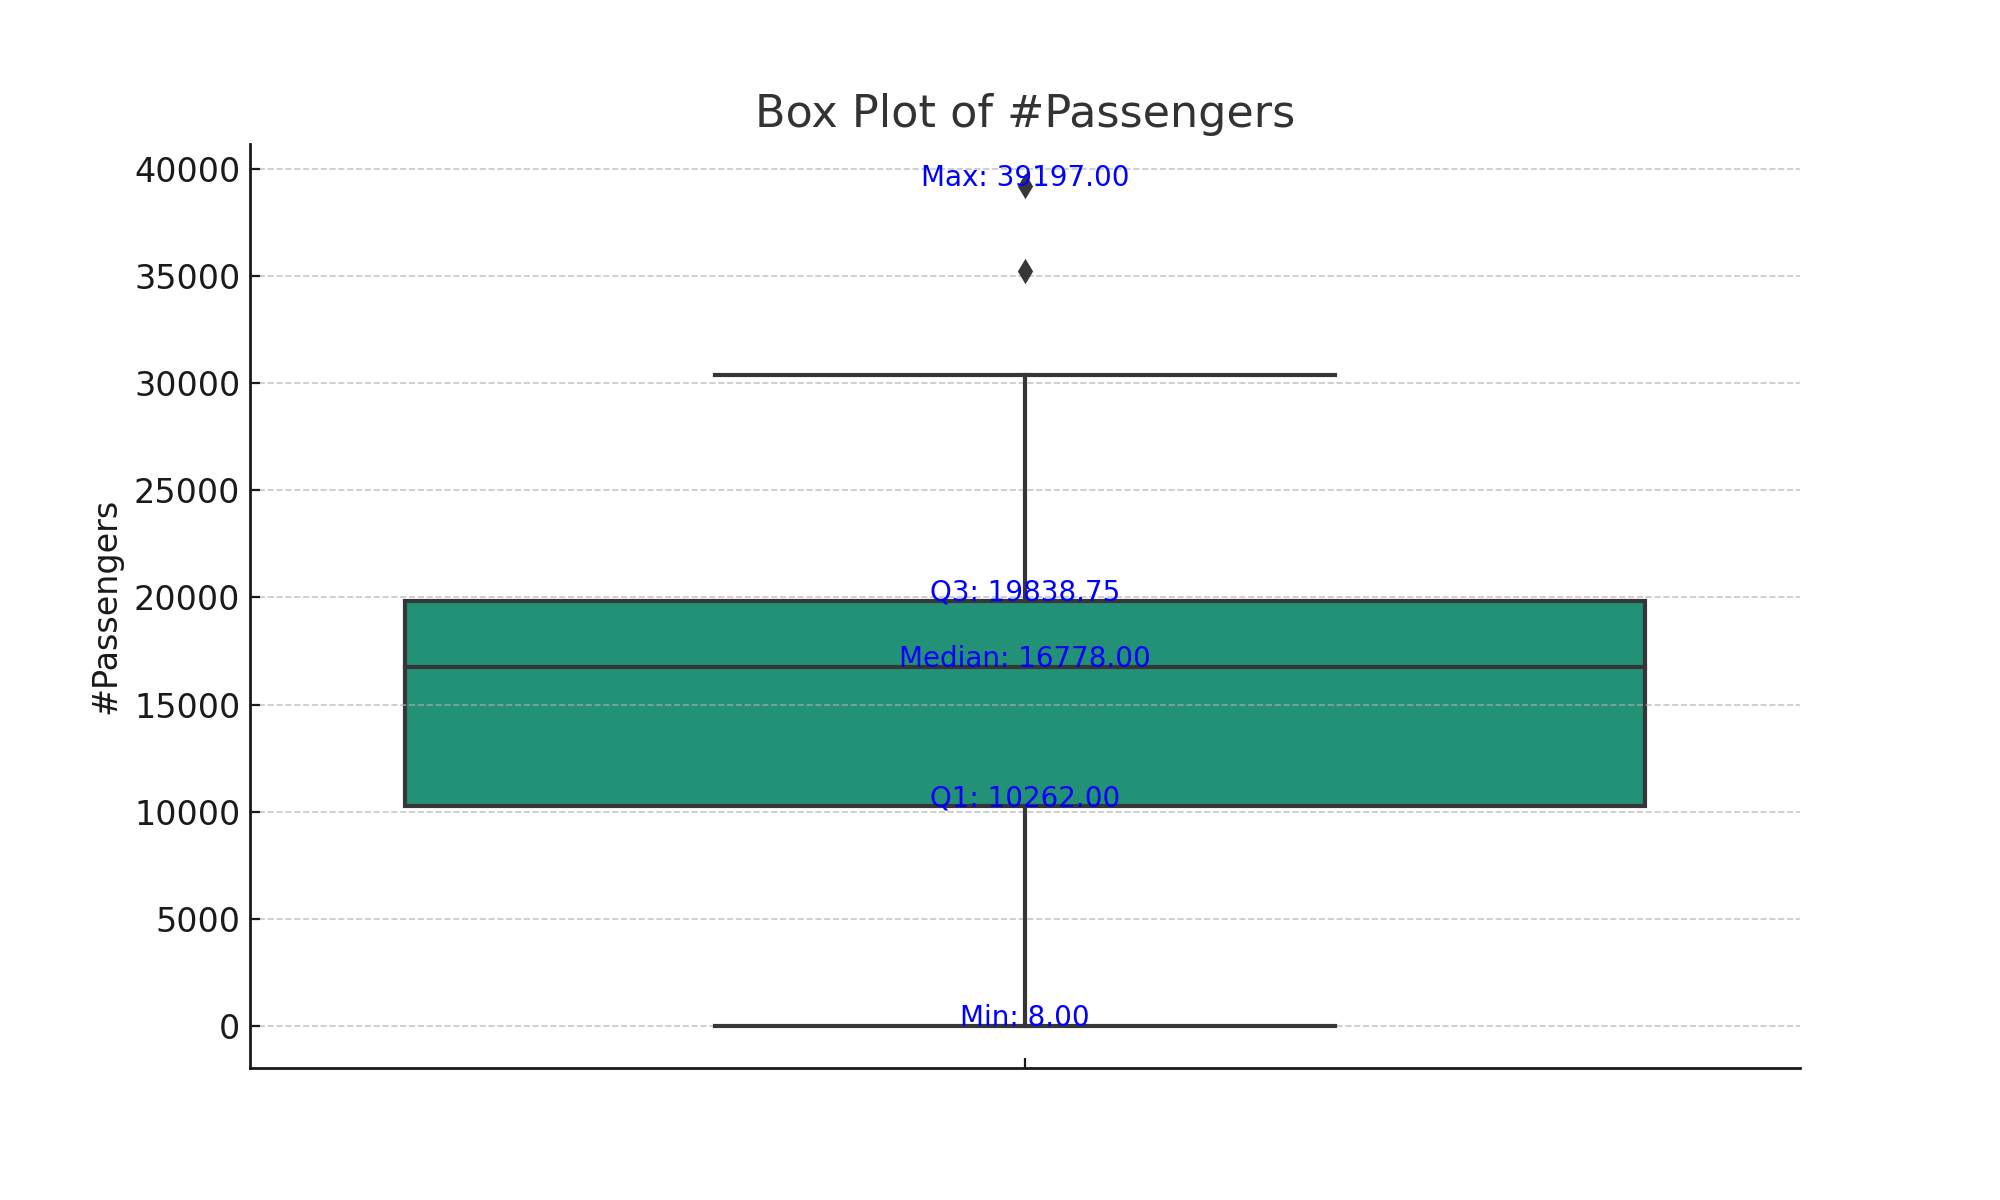

In [16]:
img = result["attachments"][0]
with open(img["file_name"], "wb") as file:
    file.write(img["file_bytes"])
Image(filename=img["file_name"], width=1000)